In [1]:
print("script started")

import numpy as np
import sys
import os
from non_layered_neural_net import nlnn
import matplotlib.pyplot as plt
import gc
import psutil
from memory_profiler import memory_usage
import pickle

np.random.seed(1)


training_run = 0
neuron_count = 300
connection_probability_dropoff = 3
connection_probability_scalar = 0.00003
input_layer_connectivity_multiplyer = 50
output_layer_connectivity_multiplyer = 20
weight_initialisation_range = 2
distances_from_input_output_layer_to_main_neuron_field = 0.1
hidden_neuron_connections = 7
input_neuron_connections = 10
output_neuron_connections = 10
inference_steps = 8
n_closes_neurons_connection_probability = "connection_prob"  # "connection_prob" /"n_closest"
activation_function = "sigmoid"  # relu
generation_size = 30
n_survivors = 3
mutation_range = 0.1
training_set_size = 1000  # maybe make 10000?
mutation_range_reducing_interval = "none"
mutation_range_reducing_factor = "none"
reducing_mutaiton_range = "no"
stochastic_mutation_range = "yes"
multiple_training_sets = "yes"
keep_best_of_n_generations_keep_n_best = "keep_n_best"
allow_topological_modification = "no"
non_uniform_distribution_in_stochastic_mutation_range = "no"


# this function produces a configuration of parameters based on an input number. this allows the python script to be run with just one parameter instead of 8
def get_configuration(index):
    neuron_counts = np.round(np.linspace(9, 19, 5) ** 2.5).astype(int)
    connection_probability_dropoffs = np.linspace(1, 4, 5)
    inference_steps = np.round(np.linspace(6, 20, 5)).astype(int)
    n_survivors = np.round(np.linspace(1, 12, 5)).astype(int)
    activation_functions = ["leaky_relu", "relu"]

    configurations = []

    for activation_function in activation_functions:
        for connection_probability_dropoff in connection_probability_dropoffs:
            for inference_step in inference_steps:
                for neuron_count in neuron_counts:
                    for n_survivor in n_survivors:
                        configuration = {
                            "neuron_count": neuron_count,
                            "connection_probability_dropoff": connection_probability_dropoff,
                            "hidden_neuron_connections": 6,
                            "inference_steps": inference_step,
                            "n_survivors": n_survivor,
                            "activation_function": activation_function,
                        }
                        configurations.append(configuration)

    return {'neuron_count': 1106, 'connection_probability_dropoff': 2.5, 'inference_steps': 6, 'activation_function': 'relu', 'n_survivors': 4}



config = {"training_run": training_run,
          "neuron_count": neuron_count,
          "connection_probability_dropoff": connection_probability_dropoff,
          "connection_probability_scalar": connection_probability_scalar,
          "input_layer_connectivity_multiplyer": input_layer_connectivity_multiplyer,
          "output_layer_connectivity_multiplyer": output_layer_connectivity_multiplyer,
          "weight_initialisation_range": weight_initialisation_range,
          "n_closes_neurons_connection_probability": n_closes_neurons_connection_probability,
          "hidden_neuron_connections": hidden_neuron_connections,
          "input_neuron_connections": input_neuron_connections,
          "output_neuron_connections": output_neuron_connections,
          "inference_steps": inference_steps,
          "activation_function": activation_function,
          "generation_size": generation_size,
          "n_survivors": n_survivors,
          "mutation_range": mutation_range,
          "training_set_size": training_set_size,
          "mutation_range_reducing_interval": mutation_range_reducing_interval,
          "mutation_range_reducing_factor": mutation_range_reducing_factor,
          "reducing_mutaiton_range": reducing_mutaiton_range,
          "stochastic_mutation_range": stochastic_mutation_range,
          "multiple_training_sets": multiple_training_sets,
          "allow_topological_modification": allow_topological_modification
          }


def load_local_mnist_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
    return (x_train, y_train), (x_test, y_test)


def one_hot_encode(x):
    out = np.zeros((len(x), max(x) + 1))
    for i in range(len(x)):
        out[i][x[i]] = 1
    return out


def create_population(population_size):
    population = []
    print("Creating networks")
    for i in range(population_size):
        net = nlnn(output_neurons=10, hidden_neurons=config["neuron_count"])
        if config["n_closes_neurons_connection_probability"] == "connection_prob":
            net.initialise_structure(connection_probability_dropoff=config["connection_probability_dropoff"], connection_probabily_scalar=config["connection_probability_scalar"],
                                     input_connection_prob_multiplyer=config["input_layer_connectivity_multiplyer"], output_connection_prob_multiplyer=config["output_layer_connectivity_multiplyer"])
        elif config["n_closes_neurons_connection_probability"] == "n_closest":
            net.initialise_structure_n_closest(hidden_neuron_connections=config["hidden_neuron_connections"], input_neuron_connections=config["input_neuron_connections"],
                                               output_neuron_connections=config["output_neuron_connections"])
        # net.initialise_randomly()
        population.append(net)
        print("|", end="")

    print("done!")
    return population


def get_perf(t):
    return t[0]


def evaluate_performance(population, x, y):
    performances = []
    print("evaluating performances", end="")
    for net in population:
        predictions = net.predict(x, config["inference_steps"])[0]
        correct_count = len(x) - (np.sum(np.abs(y - predictions)) / 2)
        performances.append((correct_count / len(x), net))
        print("|", end="")
    print(" done!", end=" ")
    # sort by best performance
    performances.sort(key=get_perf, reverse=True)
    return performances


def repopulate(evaluated_networks, mutation_range, n):
    offspring_per_network = int(population_size / n)
    parents = [i[1] for i in evaluated_networks[:n]]
    offspring = []
    for net in parents:
        net_offspring = net.reproduce(min(offspring_per_network, population_size - len(offspring)), mutation_range)
        offspring.extend(net_offspring)
    next_gen = parents + offspring
    next_gen = next_gen[:population_size]
    return next_gen


settings = get_configuration(0)
print(settings)

for i in settings.keys():
    config[i] = settings[i]

for i in config.keys():
    print(i, ":", config[i])




(train_X, train_y), (test_X, test_y) = load_local_mnist_data('mnist.npz')

y_train_ohe = one_hot_encode(train_y)
y_test_ohe = one_hot_encode(test_y)
# flatten images
x_train = train_X.reshape(len(train_X), 28 * 28)
x_test = test_X.reshape(len(test_X), 28 * 28)

x_test = np.array_split(x_test, 10)
y_test_ohe = np.array_split(y_test_ohe, 10)

performance_over_time = []
test_sets_used = []
mutation_ranges = []
validation_accuracy = []
memory_usage_list = []
memory_usage_list_2 = []
print()
try:
    f = open('performance_over_time_nlnn.pkl', 'rb') 
    performance_over_time = pickle.load(f)
    print("previous performance loaded")
except:
    print("no previous performance found")
try:
    f = open('validation_accuracy.pkl', 'rb') 
    validation_accuracy = pickle.load(f)
    print("previous validation accuracy loaded")
except:
    print("no previous validation accuracy found")
try:
    f = open('test_sets_used.pkl', 'rb') 
    test_sets_used = pickle.load(f)
    print("previous test_sets_used loaded")
except:
    print("no previous test_sets_used found")

# Training loop
# loading hyperparameters
n = config["n_survivors"]
mutation_range = config["mutation_range"]
population_size = config["generation_size"]
print_graphs = False


try:
    f = open('networks.pkl', 'rb') 
    networks = pickle.load(f)
    print("previous networks loaded")
    print("resuming previous training run")
except:
    try:
        f = open('backup/networks.pkl', 'rb') 
        networks = pickle.load(f)
        print("backup networks loaded")
        print("resuming previous training run")
    except:
        print("no previous networks found")
        networks = create_population(population_size)
        networks = evaluate_performance(networks, x_test[0], y_test_ohe[0])
        print("best performer of this generation :", networks[0][0])

        networks = repopulate(networks, mutation_range, n)



script started
{'neuron_count': 1106, 'connection_probability_dropoff': 2.5, 'inference_steps': 6, 'activation_function': 'relu', 'n_survivors': 4}
training_run : 0
neuron_count : 1106
connection_probability_dropoff : 2.5
connection_probability_scalar : 3e-05
input_layer_connectivity_multiplyer : 50
output_layer_connectivity_multiplyer : 20
weight_initialisation_range : 2
n_closes_neurons_connection_probability : connection_prob
hidden_neuron_connections : 7
input_neuron_connections : 10
output_neuron_connections : 10
inference_steps : 6
activation_function : relu
generation_size : 30
n_survivors : 4
mutation_range : 0.1
training_set_size : 1000
mutation_range_reducing_interval : none
mutation_range_reducing_factor : none
reducing_mutaiton_range : no
stochastic_mutation_range : yes
multiple_training_sets : yes
allow_topological_modification : no

previous performance loaded
previous validation accuracy loaded
previous test_sets_used loaded
previous networks loaded
resuming previous tra

In [2]:
if isinstance(networks[0], tuple):
    n = []
    for i in networks:
        n.append(i[1])
    networks = n

TypeError: isinstance() arg 2 must be a type, a tuple of types, or a union

In [3]:
y_train_ohe = one_hot_encode(train_y)
y_test_ohe = one_hot_encode(test_y)
#flatten images
x_train = train_X.reshape(len(train_X), 28*28)
x_test = test_X.reshape(len(test_X), 28*28)

x_test = np.array_split(x_test, 10)
y_test_ohe = np.array_split(y_test_ohe, 10)

x_val = x_train[:10000]
y_val = y_train_ohe[:10000]



generation 10000  test set: 0 evaluating performances|||||||||||||||||||||||||||||| done!  best: 0.634
evaluating performances| done! 

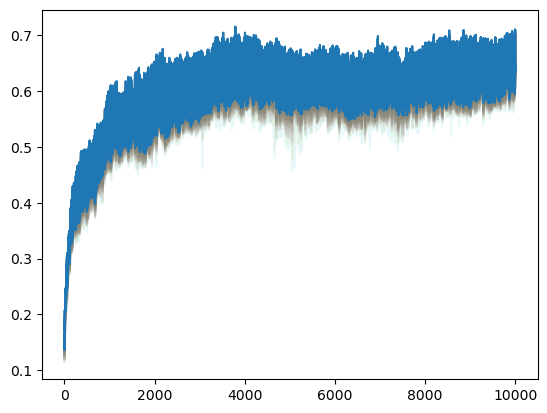

average best of last 100 generations 0.6487


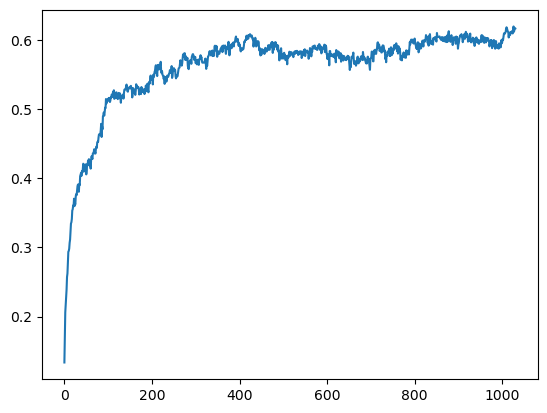

validation accuracy: 0.6166


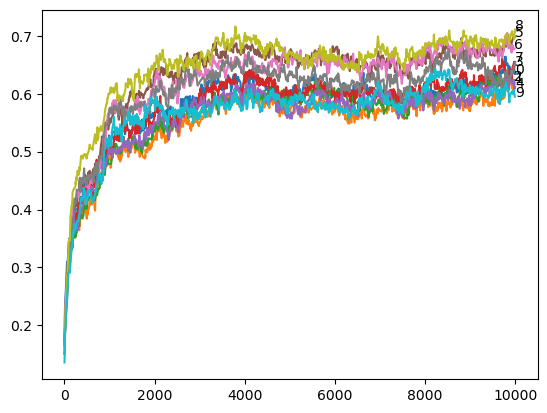

In [6]:
generations = 1
test_set = 0

for gen in range(generations):
    if config["reducing_mutaiton_range"] == "yes":
        if gen % config["mutation_range_reducing_interval"] == 0 and gen != 0:
            mutation_range /= config["mutation_range_reducing_factor"]
            print("decreasing mutation range from", mutation_range * config["mutation_range_reducing_factor"], "to", mutation_range)
    print("generation " + str(len(performance_over_time) + 1), end=" ")

    if config["multiple_training_sets"] == "yes" and gen != 0:
        test_set = np.random.randint(10)
    
    print(" test set:", test_set, end=" ")
    if(gen%10==0):
        with open('backup/networks.pkl', 'wb') as f:
            pickle.dump(networks, f)
    networks = evaluate_performance(networks, x_test[test_set], y_test_ohe[test_set])
    if(gen%10==0):
        with open('networks.pkl', 'wb') as f:
            pickle.dump(networks, f)
    
    print(" best:", networks[0][0])  # , "second:", evaluated_networks[1][0], "third:", evaluated_networks[2][0])
    performance_over_time.append(np.array(networks)[:, 0])
    test_sets_used.append(test_set)
    generational_mutation_range = mutation_range
    if config["stochastic_mutation_range"] == "yes":  # change back
        generational_mutation_range = np.random.rand() * mutation_range
    mutation_ranges.append(generational_mutation_range)
    #print("mutating in range:", generational_mutation_range)

    next_gen = repopulate(networks, generational_mutation_range, config["n_survivors"])

    del networks
    networks = next_gen
    if (gen % 10 == 0) and print_graphs:
        print("average best of last 100 generations", np.average(np.array(performance_over_time)[-100:, 0]))
    gc.collect()
    if(gen%10==0):
        val_accuracy = evaluate_performance([networks[0]], x_val, y_val)[0][0]
        validation_accuracy.append(val_accuracy)
        plt.plot(np.array(performance_over_time), alpha= 0.1)
        plt.plot(np.array(performance_over_time)[:,0])
        plt.show()
        print("average best of last 100 generations",np.average(np.array(performance_over_time)[-100:,0]))  
        plt.plot(validation_accuracy)
        plt.show()
        print("validation accuracy:", val_accuracy)
        with open('performance_over_time_nlnn.pkl', 'wb') as f:
            pickle.dump(performance_over_time, f)
        with open('validation_accuracy.pkl', 'wb') as f:
            pickle.dump(validation_accuracy, f)
        with open('test_sets_used.pkl', 'wb') as f:
            pickle.dump(test_sets_used, f)
        set_perf = [[[],[]] for i in range(10)]
        for i in range(len(test_sets_used)):
            set_perf[test_sets_used[i]][0].append(np.array(performance_over_time)[:,0][len(performance_over_time)-len(test_sets_used)+i])
            set_perf[test_sets_used[i]][1].append(len(performance_over_time)-len(test_sets_used)+i)
        for i in range(10):
            plt.plot(set_perf[i][1], set_perf[i][0])
            if set_perf[i][1]:  # check if list is not empty
                plt.text(set_perf[i][1][-1], set_perf[i][0][-1], str(i))
        plt.show()
    
    gc.collect()
    


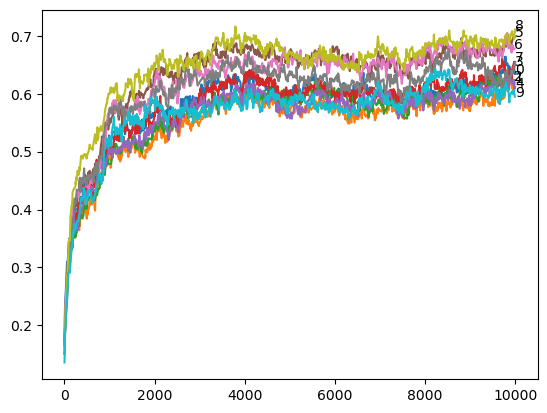

In [7]:
set_perf = [[[],[]] for i in range(10)]
for i in range(len(test_sets_used)):
    set_perf[test_sets_used[i]][0].append(np.array(performance_over_time)[:,0][len(performance_over_time)-len(test_sets_used)+i])
    set_perf[test_sets_used[i]][1].append(len(performance_over_time)-len(test_sets_used)+i)
for i in range(10):
    plt.plot(set_perf[i][1], set_perf[i][0])
    if set_perf[i][1]:  # check if list is not empty
        plt.text(set_perf[i][1][-1], set_perf[i][0][-1], str(i))
plt.show()

In [8]:
with open('networks.pkl', 'wb') as f:
            pickle.dump(networks, f)     
with open('performance_over_time_nlnn.pkl', 'wb') as f:
            pickle.dump(performance_over_time, f)
with open('validation_accuracy.pkl', 'wb') as f:
            pickle.dump(validation_accuracy, f)

In [9]:
folder_name = 'run_' + str(training_run)
suffix = 1

while os.path.exists(folder_name):
    suffix += 1
    folder_name = f"{folder_name}_{suffix}"

os.makedirs(folder_name)

print("saving files")

performance_over_time_array = np.array(performance_over_time, dtype=np.float64)

np.savetxt(folder_name + '/training_run_' + str(training_run) + '_performance.csv', performance_over_time_array, delimiter=',')
print("performances saved successfully")
np.savetxt(folder_name + '/training_run_' + str(training_run) + '_test_sets_used.csv', test_sets_used, delimiter=',')
print("test sets saved successfully")
np.savetxt(folder_name + '/training_run_' + str(training_run) + '_mutation_ranges.csv', mutation_ranges, delimiter=',')
print("mutation ranges saved successfully")
np.save(folder_name + '/training_run_' + str(training_run) + '_config.npy', np.array(config))
print("config saved successfully \n COMPLETED RUN SCCESSFULLY"

SyntaxError: incomplete input (2025379821.py, line 21)

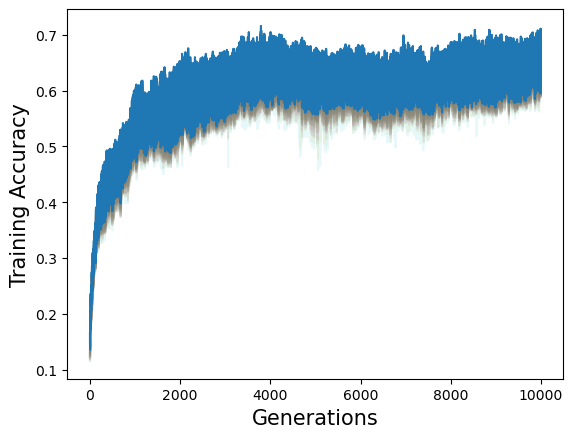

ValueError: x and y must have same first dimension, but have shapes (1,) and (1031,)

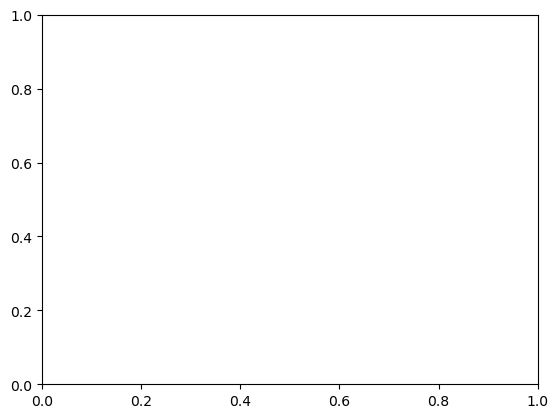

In [25]:
import matplotlib.font_manager as fm


plt.plot(np.array(performance_over_time), alpha= 0.1)
plt.plot(np.array(performance_over_time)[:,0])
plt.xlabel("Generations", fontsize=15)
plt.ylabel("Training Accuracy", fontsize=15)

plt.savefig("generated_pdf_plots/nlnn_training_accuracy.pdf")
plt.show()

font_path = '/Users/hannes/Library/Fonts/CenturyGothic.ttf'
font = fm.FontProperties(fname=font_path, size=16)

plt.plot(np.array(len(validation_accuracy))*10,validation_accuracy)
plt.xlabel('Generations', fontsize=16, color='black', fontproperties=font)
plt.ylabel('Validation Accuracy', fontsize=16, color='black', fontproperties=font)
#plt.savefig("lnn_validation_accuracy.pdf")
plt.show()


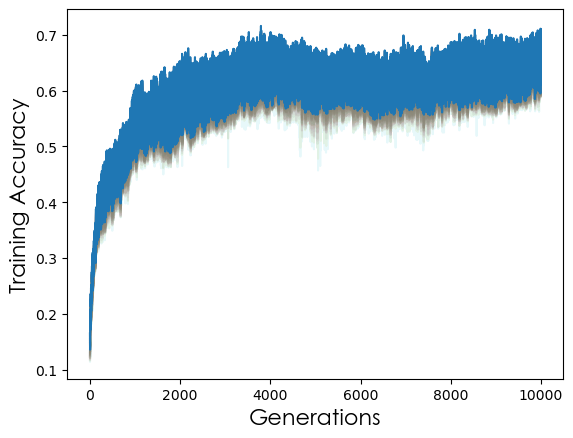

In [29]:
"""plt.plot(validation_accuracy)
plt.xlabel("Generations", fontsize=15)
plt.ylabel("Validation Accuracy", fontsize=15)
plt.savefig("generated_pdf_plots/nlnn_validation_accuracy.pdf")
plt.show()

"""
plt.plot(np.array(performance_over_time), alpha= 0.1)
plt.plot(np.array(performance_over_time)[:,0])
plt.xlabel('Generations', fontsize=16, color='black', fontproperties=font)
plt.ylabel('Training Accuracy', fontsize=16, color='black', fontproperties=font)
plt.savefig("nlnn_training_accuracy.pdf")
plt.show()

In [33]:
print(max(np.array(performance_over_time)[:,0]))
print(max(validation_accuracy))

0.716
0.6195
